In [1]:
using Distributions
using Plots
using BenchmarkTools
using Profile

In [2]:
function energy(M) 
    e = 0
    n = size(M)[1]
    for i in 1:n #parallelize this 
        e += sum(M[i].^2)
        for j in i+1:n #parallelize this 
            e += 1/sum((M[i] .- M[j]).^2)
        end
    end
    return e
end


energy (generic function with 1 method)

In [3]:
function monte(x,T,T0)
    n = size(x)[1]
    for i = 1:n # Cant be parallelized dependent loop
        a = rand(1:n)
        l = sqrt(T/T0)
        dn = x[a] + rand(Uniform(-l, l), 2)
        dE = sum(dn.^2) - sum(x[a].^2)
    
        for j = 1:n 
            if  j!=a  
                dE += 1/sum((dn .- x[j]).^2) - 1/sum((x[a] .- x[j]).^2) #1/r^2
                #dE += 1/sum(abs.(dn .- x[j])) - 1/sum(abs.(x[a] .- x[j]))
            end
        end

        q = min(1,exp(-dE/T))
        m = rand()
            if q>m
                x[a] = dn
            end
    end
    return x
end


monte (generic function with 1 method)

In [6]:
function monte_bounded(x,T,T0)
    n = size(x)[1]
    for i = 1:n # Cant be parallelized dependent loop
        a = rand(1:n)
        l = sqrt(T/T0)
        dn = x[a] + rand(Uniform(-l, l), 2)
        if abs(dn[1]) > 2 || abs(dn[2]) > 2
            break
        else
            dE = sum(dn.^2) - sum(x[a].^2)
            
            for j = 1:n # Can be parallelized, maybe use the sum trick
                if  j!=a  #remove this if branch and integrate into main code
                    dE += 1/sum((dn .- x[j]).^2) - 1/sum((x[a] .- x[j]).^2) #1/r^2
                    #dE += 1/sum(abs.(dn .- x[j])) - 1/sum(abs.(x[a] .- x[j]))
                end

            end
            q = min(1,exp(-dE/T))
            m = rand()
                if q>m
                    x[a] = dn
                end
        end
    end
    return x
end


monte_bounded (generic function with 1 method)

In [7]:
function monte_new(x,T,T0)
    n = size(x)[1]
    @simd for i = 1:n # Cant be parallelized dependent loop
        a = rand(1:n)
        l = sqrt(T/T0)
        dn = x[a] + rand(Uniform(-l, l), 2)
        dE = sum(dn.^2) - sum(x[a].^2)
    
        @simd for j = 1:n # Can be parallelized, maybe use the sum trick
            if  j!=a  #remove this if branch and integrate into main code
            @inbounds  dE += 1/sum((dn .- x[j]).^2) - 1/sum((x[a] .- x[j]).^2)
            end
             
        end
        q = min(1,exp(-dE/T))
        m = rand()
            if q>m
                x[a] = dn
            end
    end
    return x
end


monte_new (generic function with 1 method)

In [8]:
function monte_new_threaded(x,T,T0)
    n = size(x)[1]
    for i = 1:n # Cant be parallelized dependent loop
        a = rand(1:n)
        l = sqrt(T/T0)
        dn = x[a] + rand(Uniform(-l, l), 2)
        dE = sum(dn.^2) - sum(x[a].^2)

        temp = zeros(Float64,Threads.nthreads())
        Threads.@threads for j = 1:n 
            if  j!=a  
            #@inbounds  dE += 1/sum((dn .- x[j]).^2) - 1/sum((x[a] .- x[j]).^2)
            temp[Threads.threadid()] += 1/sum((dn .- x[j]).^2) - 1/sum((x[a] .- x[j]).^2)        
            end
    
        end
        dE += sum(temp)
        q = min(1,exp(-dE/T))
        m = rand()
            if q>m
                x[a] = dn
            end
    end
    return x
end


monte_new_threaded (generic function with 1 method)

In [18]:
x = [rand(Uniform(-1, 1), 2) for i in 1:20 ] #list of all particles
    
@profile monte(x,10,1)

20-element Vector{Vector{Float64}}:
 [-1.1927850973430394, 2.1427265568866836]
 [-2.447259684182492, 0.8713927083589004]
 [-0.6087640321477605, -0.9178691036474333]
 [-0.2243376152859422, 0.06668359453132444]
 [4.435007702937009, -1.1170265348806883]
 [0.24663832931776564, -0.9953510477566612]
 [0.6468256164125654, -0.9194430578396755]
 [-0.9485694331639789, -0.309624114173789]
 [0.7874858095168067, -0.28479376060102]
 [0.5475842670214397, -0.27523886862593283]
 [-0.3220780106041874, -0.6597847835723378]
 [0.5566077048287448, 0.06081497053638829]
 [-2.2602766465421027, -0.8012131857961768]
 [0.7657304673851737, -1.2913413223065173]
 [-2.014901508779258, -1.1411721469799199]
 [-2.6248041305581875, -1.0773993767656975]
 [-0.05335581320274607, -0.32665692417985803]
 [2.18621484479453, 2.538059149747395]
 [-0.30244838321813705, -0.4715164759938948]
 [-0.20699104252809208, 0.4621688407544058]

In [35]:
Profile.Allocs.clear()

In [36]:
using PProf

In [37]:
Profile.Allocs.@profile sample_rate=1 monte(x,10,1)

20-element Vector{Vector{Float64}}:
 [0.3464611513041602, 3.163485367266885]
 [-2.797671122581995, 3.6866233264512855]
 [2.624128893536912, 4.2372573334496915]
 [-0.44738763032162154, 2.255844712677268]
 [3.7562289215080975, -1.2076038017204778]
 [0.7406416073720097, 1.5755787380004156]
 [-0.6318768568629844, 2.0922941514534155]
 [-1.5928691678408957, 0.5952116865935462]
 [-3.9658380869867753, -1.8608100498001172]
 [2.2795800505169863, 0.7346698407016183]
 [2.604664309833181, -2.0851850616031493]
 [0.5566077048287448, 0.06081497053638829]
 [-1.360616556201723, 0.961749945761845]
 [1.7290033658110802, -0.05206296297484081]
 [-3.9461800099790603, -0.23045507929680809]
 [-0.8335285468731009, -0.3322921960728791]
 [-6.657270751711097, 0.1651778853308037]
 [1.3497928236642562, -0.9397418613756727]
 [-3.233440422230844, 2.6430753443123005]
 [4.636320439400835, -1.4610008463284925]

In [23]:
function profile_monte(n)
    for i=1:n
        x = [rand(Uniform(-1, 1), 2) for i in 1:20 ] #list of all particles
        monte(x,10,1)
    end    
end

profile_monte (generic function with 1 method)

In [38]:
PProf.Allocs.pprof(from_c=false)

Analyzing 840 allocation samples...   0%|                |  ETA: 0:01:00

Analyzing 840 allocation samples... 100%|████████████████| Time: 0:00:06


"alloc-profile.pb.gz"

Main binary filename not available.
Serving web UI on http://localhost:62261


In [29]:
ProfileView.view()

Gtk.GtkWindowLeaf(name="", parent, width-request=-1, height-request=-1, visible=TRUE, sensitive=TRUE, app-paintable=FALSE, can-focus=FALSE, has-focus=FALSE, is-focus=FALSE, focus-on-click=TRUE, can-default=FALSE, has-default=FALSE, receives-default=FALSE, composite-child=FALSE, style, events=0, no-show-all=FALSE, has-tooltip=FALSE, tooltip-markup=NULL, tooltip-text=NULL, window, opacity=1.000000, double-buffered, halign=GTK_ALIGN_FILL, valign=GTK_ALIGN_FILL, margin-left, margin-right, margin-start=0, margin-end=0, margin-top=0, margin-bottom=0, margin=0, hexpand=FALSE, vexpand=FALSE, hexpand-set=FALSE, vexpand-set=FALSE, expand=FALSE, scale-factor=1, border-width=0, resize-mode, child, type=GTK_WINDOW_TOPLEVEL, title="Profile", role=NULL, resizable=TRUE, modal=FALSE, window-position=GTK_WIN_POS_NONE, default-width=800, default-height=600, destroy-with-parent=FALSE, hide-titlebar-when-maximized=FALSE, icon, icon-name=NULL, screen, type-hint=GDK_WINDOW_TYPE_HINT_NORMAL, skip-taskbar-hint

In [20]:
using Pkg
Pkg.add("ProfileView")

    Updating registry at `~/.julia/registries/General`


    Updating git-repo `https://github.com/JuliaRegistries/General.git`


   Resolving package versions...


   Installed LeftChildRightSiblingTrees ─ v0.2.0
   Installed AbstractTrees ────────────── v0.4.4
   Installed IntervalSets ─────────────── v0.7.4
   Installed Observables ──────────────── v0.5.4


   Installed ProfileView ──────────────── v1.7.1
   Installed GtkObservables ───────────── v1.2.9
   Installed MethodAnalysis ───────────── v0.4.13
   Installed FileIO ───────────────────── v1.16.1


   Installed FlameGraphs ──────────────── v1.0.0


    Updating `~/.julia/environments/v1.9/Project.toml`
  [c46f51b8] + ProfileView v1.7.1
    Updating `~/.julia/environments/v1.9/Manifest.toml`
 

 [1520ce14] + AbstractTrees v0.4.4
  [5789e2e9] + FileIO v1.16.1
  [08572546] + FlameGraphs v1.0.0
  [8710efd8] + GtkObservables v1.2.9
  [9b13fd28] + IndirectArrays v1.0.0
  [8197267c] + IntervalSets v0.7.4
  [1d6d02ad] + LeftChildRightSiblingTrees v0.2.0
  [85b6ec6f] + MethodAnalysis v0.4.13
  [510215fc] + Observables v0.5.4
  [c46f51b8] + ProfileView v1.7.1
  [d5f540fe] + RoundingIntegers v1.1.0


Precompiling 

project...


  ✓ IndirectArrays
  ✓ RoundingIntegers


  ✓ IntervalSets


  ✓ Observables


  ✓ AbstractTrees


  ✓ MethodAnalysis


  ✓ LeftChildRightSiblingTrees


  ✓ FileIO


  ✓ Plots → FileIOExt


  ✓ FlameGraphs


  ✓ GtkObservables


  ✓ ProfileView
  12 dependencies successfully precompiled in 39 seconds. 178 already precompiled.
  2 dependencies had warnings during precompilation:
┌ GtkObservables [8710efd8-4ad6-11eb-33ea-2d5ceb25a41c]
│  Gtk-Message: 20:32:46.186: Failed to load module "canberra-gtk-module"
│  Gtk-Message: 20:32:46.187: Failed to load module "canberra-gtk-module"
└  
┌ ProfileView [c46f51b8-102a-5cf2-8d2c-8597cb0e0da7]
│  Gtk-Message: 20:33:10.411: Failed to load module "canberra-gtk-module"
│  Gtk-Message: 20:33:10.413: Failed to load module "canberra-gtk-module"
└  


In [21]:
using ProfileView

Gtk-Message: 20:33:26.144: Failed to load module "canberra-gtk-module"
Gtk-Message: 20:33:26.146: Failed to load module "canberra-gtk-module"


In [9]:
Threads.nthreads()

6

In [94]:
x = [rand(Uniform(-1, 1), 2) for i in 1:1000 ] #list of all particles
@benchmark monte_new_threaded($x,1,10)

BenchmarkTools.Trial: 56 samples with 1 evaluation.
 Range (min … max):  59.114 ms … 111.577 ms  ┊ GC (min … max):  0.00% … 36.18%
 Time  (median):     97.905 ms               ┊ GC (median):    36.20%
 Time  (mean ± σ):   89.872 ms ±  18.255 ms  ┊ GC (mean ± σ):  27.46% ± 17.52%

      ▂ ▂                                     ▂█  ▅  ▅ █▂       
  ▅▅█▅█▅██▁▅▅▁▁▅▁▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▁▁▁▁▁▁▁▁▁▅███▁█▁▅█▅████▁▅█ ▁
  59.1 ms         Histogram: frequency by time          110 ms <

 Memory estimate: 156.32 MiB, allocs estimate: 2040954.

In [95]:
x = [rand(Uniform(-1, 1), 2) for i in 1:1000 ] #list of all particles
@benchmark monte_new($x,1,10)

BenchmarkTools.Trial: 25 samples with 1 evaluation.
 Range (min … max):  169.817 ms … 215.828 ms  ┊ GC (min … max): 17.97% … 23.07%
 Time  (median):     201.646 ms               ┊ GC (median):    19.13%
 Time  (mean ± σ):   200.646 ms ±  10.540 ms  ┊ GC (mean ± σ):  19.98% ±  2.58%

  ▁                    ▁▁ ▁    ▁   ▁ █ ▁█▁  █ ▁ ▁ ██     ▁▁ ▁▁▁  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁██▁█▁▁▁▁█▁▁▁█▁█▁███▁▁█▁█▁█▁██▁▁▁▁▁██▁███ ▁
  170 ms           Histogram: frequency by time          216 ms <

 Memory estimate: 152.74 MiB, allocs estimate: 2002000.

In [61]:
x = [rand(Uniform(-1, 1), 2) for i in 1:50 ] #list of all particles
@benchmark monte($x,1,10)

BenchmarkTools.Trial: 8249 samples with 1 evaluation.
 Range (min … max):  299.425 μs …  16.594 ms  ┊ GC (min … max):  0.00% … 95.80%
 Time  (median):     402.426 μs               ┊ GC (median):     0.00%
 Time  (mean ± σ):   590.873 μs ± 951.965 μs  ┊ GC (mean ± σ):  13.97% ±  8.79%

   █                                                             
  ▄██▆▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  299 μs           Histogram: frequency by time         1.69 ms <

 Memory estimate: 398.44 KiB, allocs estimate: 5100.

In [4]:
function main()

    N = (10^4) #Temp points

    n = 10#5*(10^2) #particles 
    
    T0 = 10
    T1 = LinRange(0.000001,T0,N)
    
    x = [rand(Uniform(-1, 1), 2) for i in 1:n ] #list of all particles
    
    println(energy(x))
    
    for i=1:N 
        #println(i)
        x = monte(x,T1[N-i+1],T0)#monte_new_threaded(x,T1[N-i+1],T0)
    end
    
    print(energy(x))
    return x    
end

main (generic function with 1 method)

In [5]:
x_test = main();

206.102176690475


36.78162679290204

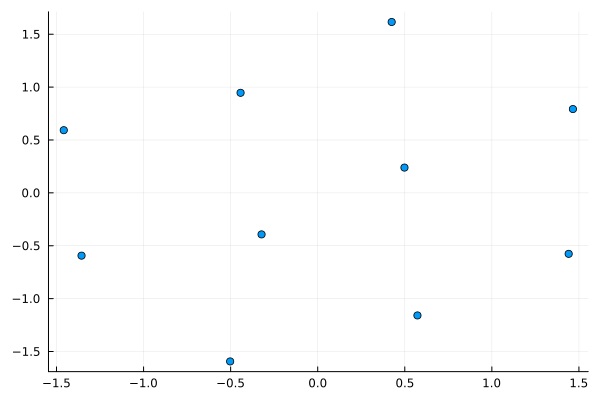

In [6]:
g1 = [x_test[i][1] for i=1:size(x_test)[1]]
g2 = [x_test[i][2] for i=1:size(x_test)[1]]
scatter(g1,g2,legend=false)


In [ ]:

main()


#z = sum(x[i].^2)
z = zeros(Float64, n)

for i =1:n
    z[i] = sqrt( sum(x[i].^2) )
end

histogram(z)


g1 = [x[i][1] for i=1:size(x)[1]]
g2 = [x[i][2] for i=1:size(x)[1]]


scatter(g1,g2)